In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Load reduced dataset
df = pd.read_csv("../data/heart_disease_selected_features.csv")

# Separate features and target
X = df.drop(columns=["num"])   # or "target" depending on your dataset
y = df["num"]

# Convert to binary classification if needed (num > 0 → 1)
y = (y > 0).astype(int)

print("Dataset shape:", X.shape, "Target distribution:\n", y.value_counts())


Dataset shape: (303, 13) Target distribution:
 num
0    164
1    139
Name: count, dtype: int64


In [2]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (242, 13) Test size: (61, 13)


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, solver="liblinear"),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(kernel="rbf", probability=True, random_state=42)
}


In [4]:
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_prob) if y_prob is not None else None
    }

pd.DataFrame(results).T


,Accuracy,Precision,Recall,F1,AUC
Logistic Regression,0.868852,0.812500,0.928571,0.866667,0.951299
Decision Tree,0.803279,0.735294,0.892857,0.806452,0.810065
Random Forest,0.901639,0.843750,0.964286,0.900000,0.951299
SVM,0.868852,0.833333,0.892857,0.862069,0.943723


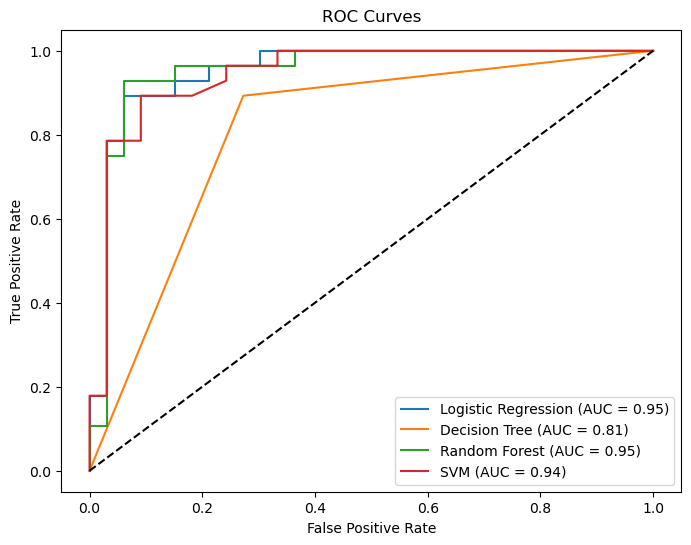

In [5]:
plt.figure(figsize=(8,6))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc = roc_auc_score(y_test, y_prob)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()


In [6]:
import joblib
import os

os.makedirs("../models", exist_ok=True)

for name, model in models.items():
    filename = f"../models/{name.replace(' ', '_').lower()}.pkl"
    joblib.dump(model, filename)
    print(f"Saved {name} model → {filename}")


Saved Logistic Regression model → ../models/logistic_regression.pkl
Saved Decision Tree model → ../models/decision_tree.pkl
Saved Random Forest model → ../models/random_forest.pkl
Saved SVM model → ../models/svm.pkl
